# Raster reprojection and resampling

In [1]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, \
reproject, Resampling
from shapely.geometry import box
import matplotlib.pyplot as plt
from GISops import project_raster, clip_raster

% matplotlib inline

### start with the original window from the NED 10-m DEM

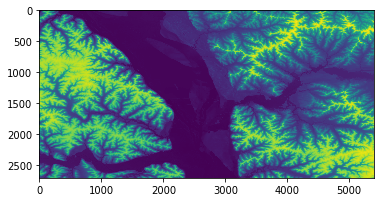

In [2]:
with rasterio.open('data/lc.tif') as src:
    plt.imshow(src.read(1))

### reproject to NAD 83 UTM zone 16N; resample to 30m resolution
* based on the recipe in the `rasterio` documentation:
https://mapbox.github.io/rasterio/topics/reproject.html
* resampling options can also be found [here](https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py)


In [3]:
dst_crs = 'EPSG:26916' #{'+init': '26916'}
with rasterio.open('data/lc.tif') as src:
    
    ### Estimate an optimal output shape using gdal
    affine, width, height = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds,
    resolution=(30, 30))
    
    kwargs = src.meta.copy()
    kwargs.update({
            'crs': dst_crs,
            'transform': affine,
            'affine': affine,
            'width': width,
            'height': height,
            'driver': src.driver
            })
    with rasterio.open('data/lc_pr.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.affine,
                src_crs=src.crs,
                dst_transform=affine,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear,
                num_threads=2)

/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The 'affine' kwarg in rasterio.open() is deprecated at 1.0 and only remains to ease the transition.  Please switch to the 'transform' kwarg.  See https://github.com/mapbox/rasterio/issues/86 for details.
/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
affine

Affine(30.0, 0.0, 137690.1309763576,
       0.0, -30.0, 4881787.158556846)

### the UTM grid is not quite parallel to lat/lon at this location

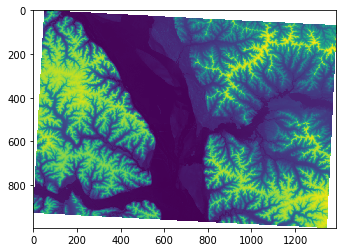

In [5]:
with rasterio.open('data/lc_pr.tif') as src:
    img = src.read(1)
    img[img < 0] = np.nan
    plt.imshow(img)

### reproject the raster back to NAD 83 lat/lon using `GIS_utils`
* `project_raster` wraps the above rasterio code
* set the resolution back to the original 10 m (upsampling)

In [6]:
with rasterio.open('data/lc.tif') as src:
    project_raster('data/lc_pr.tif', 
                   'data/lc_pr2.tif', 
                   'EPSG:4269', resolution=src.res)

reprojecting data/lc_pr.tif...
from:
+init=epsg:26916, res: 3.00e+01, 3.00e+01
to:
+init=epsg:4269, res: 9.26e-05, 9.26e-05...


/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  after removing the cwd from sys.path.


wrote data/lc_pr2.tif.


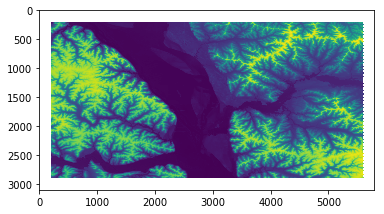

In [7]:
with rasterio.open('data/lc_pr2.tif') as src:
    img = src.read(1)
    img[img < 0] = np.nan
    plt.imshow(img)

### Clip the reprojected raster back to the original bounds

In [8]:
with rasterio.open('data/lc.tif') as src:
    clip_raster('data/lc_pr2.tif', [box(*src.bounds)], 'data/lc_pr3.tif')

+init=epsg:4269 +init=epsg:4269
clipping data/lc_pr2.tif...
wrote data/lc_pr3.tif
Done.


### Compare the reprojected raster with the original

In [9]:
with rasterio.open('data/lc.tif') as src:
    with rasterio.open('data/lc_pr3.tif') as src2:
        original = src.read(1)
        nrow, ncol = original.shape
        reprojected = src2.read(1)[:nrow, -ncol:]

<function matplotlib.pyplot.tight_layout>

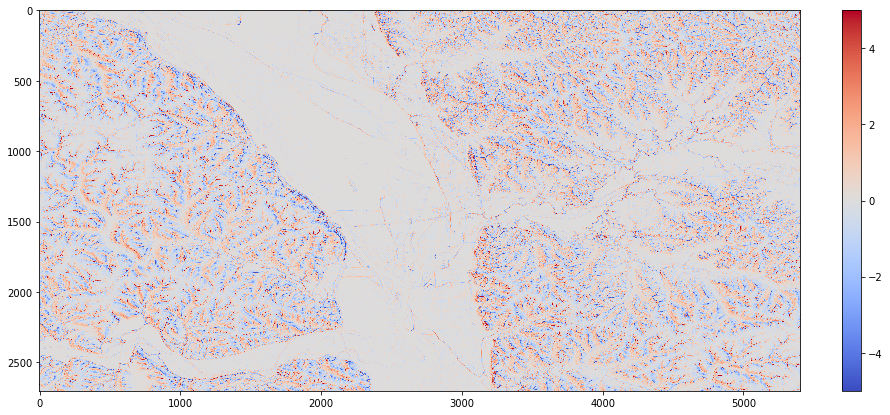

In [10]:
dif = reprojected - original
dif[dif < -1000] = np.nan
fig, ax = plt.subplots(figsize=(15, 7))
plt.imshow(dif, vmin=-5, vmax=5, cmap='coolwarm')
plt.colorbar(fraction=0.03)
plt.tight_layout

### write out the comparison to a file

In [11]:
with rasterio.open('data/lc.tif') as src:
    
    kwargs = src.meta.copy()
    del kwargs['transform']
    
    with rasterio.open('data/lc_pr3_comp.tif', 'w', **kwargs) as dest:
        dest.write(dif, 1)

/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/rasterio/__init__.py:282: NotGeoreferencedWarning: Dataset has no geotransform set. Default transform will be applied (Affine.identity())
  s.start()
